Aspect to investigate on this data science project:    
The imagined task from AirBnB team was to investigate wheter host's communicational behaviour
reflects superhostness.  
AirBnB has been struggling how to define how to separate hosts from superhosts, problem has arisen from the increasing number of superhosts, inflating the very meaning of it.  

In [800]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix

### Bring data to Pandas dataframe  
Inspect the first rows

In [801]:
path_to_file = 'data/listings.csv'
df = pd.read_csv(path_to_file)
df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20250306035151,2025-03-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.82,4.73,4.79,NaN,f,1,1,0,0,3.60
1,5769,https://www.airbnb.com/rooms/5769,20250306035151,2025-03-11,previous scrape,NW Austin Room,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.94,4.77,4.92,NaN,f,1,0,1,0,1.65
2,6413,https://www.airbnb.com/rooms/6413,20250306035151,2025-03-13,city scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/hosting/Hosti...,13879,...,4.98,4.87,4.93,NaN,f,1,1,0,0,0.66


- Selecting columns to be used in this work  


In [802]:
cols = ['host_response_time', 'host_response_rate', 'review_scores_communication', 'host_is_superhost']
df = df[cols]
df.head()

,host_response_time,host_response_rate,review_scores_communication,host_is_superhost
0,within a few hours,100%,4.82,t
1,NaN,NaN,4.94,f
2,within a day,100%,4.98,t
3,within an hour,100%,4.98,t
4,within a day,90%,4.88,f


Exclude '%' from host_response_rate  
true for 't' and false for 'f' in host_is_superhost

In [803]:
df['host_response_rate'] = df['host_response_rate'].str[:-1]
df['host_is_superhost'] = df['host_is_superhost'].replace({'t': 'true', 'f': 'false'})

df.head()

,host_response_time,host_response_rate,review_scores_communication,host_is_superhost
0,within a few hours,100,4.82,true
1,NaN,NaN,4.94,false
2,within a day,100,4.98,true
3,within an hour,100,4.98,true
4,within a day,90,4.88,false


Rename columns for convenience

In [804]:

df.rename(columns={'host_is_superhost': 'is_superhost', 'host_response_rate': 'response_rate', 
                   'host_response_time':'response_time', 'review_scores_communication': 'comms_score'}, inplace=True)
df.head(3)

,response_time,response_rate,comms_score,is_superhost
0,within a few hours,100,4.82,true
1,NaN,NaN,4.94,false
2,within a day,100,4.98,true


- NaN values  
We see that ~4600 rows are lost when dropping rows with missing values.  
Remaining (10816 entries) is still a good size dataset.   
Another option would be to fill the missing values by calculating e.g. a mean from entries with values.  
Because the number of rows with missing values is third of the dataset I opt for dropping rows with missing values to avoid skewing.  

In [805]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(15431, 4)
(9143, 4)


### Inspecting data
#### Visualizing features  
- Response time

<AxesSubplot:xlabel='response_time', ylabel='count'>

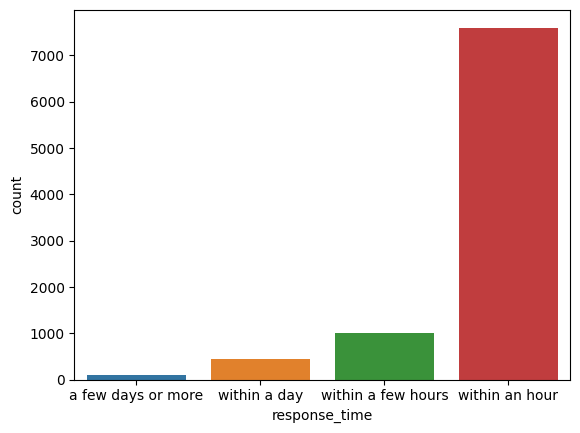

In [806]:
sns.countplot(data=df.sort_values('response_time'), x='response_time', )

- Response rate  
Changing datatype to int  
Temporarily sort by ascending values for visualization

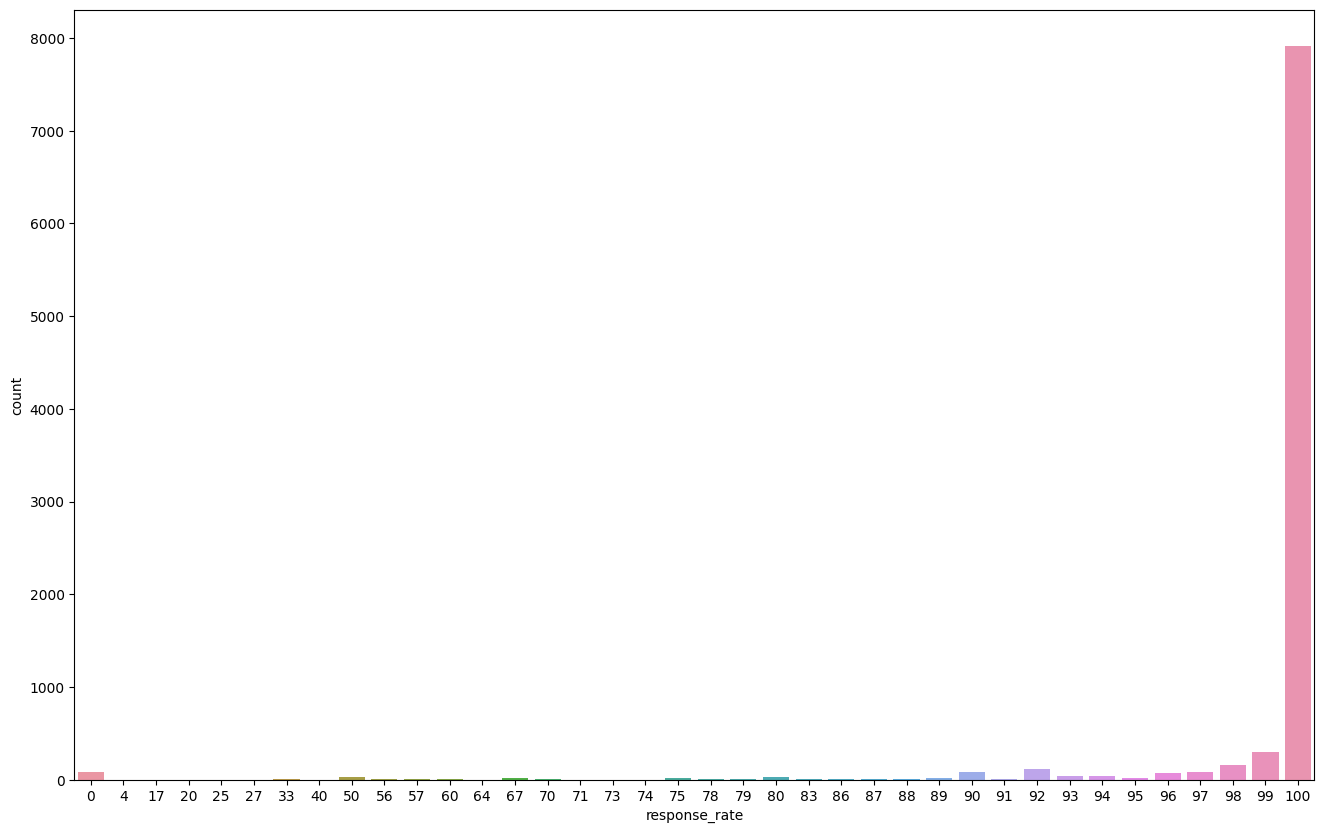

In [807]:
df['response_rate'] = df['response_rate'].astype(int)
graph = sns.countplot(data=df.sort_values('response_rate'), x= 'response_rate', )
graph.figure.set_size_inches(16, 10)


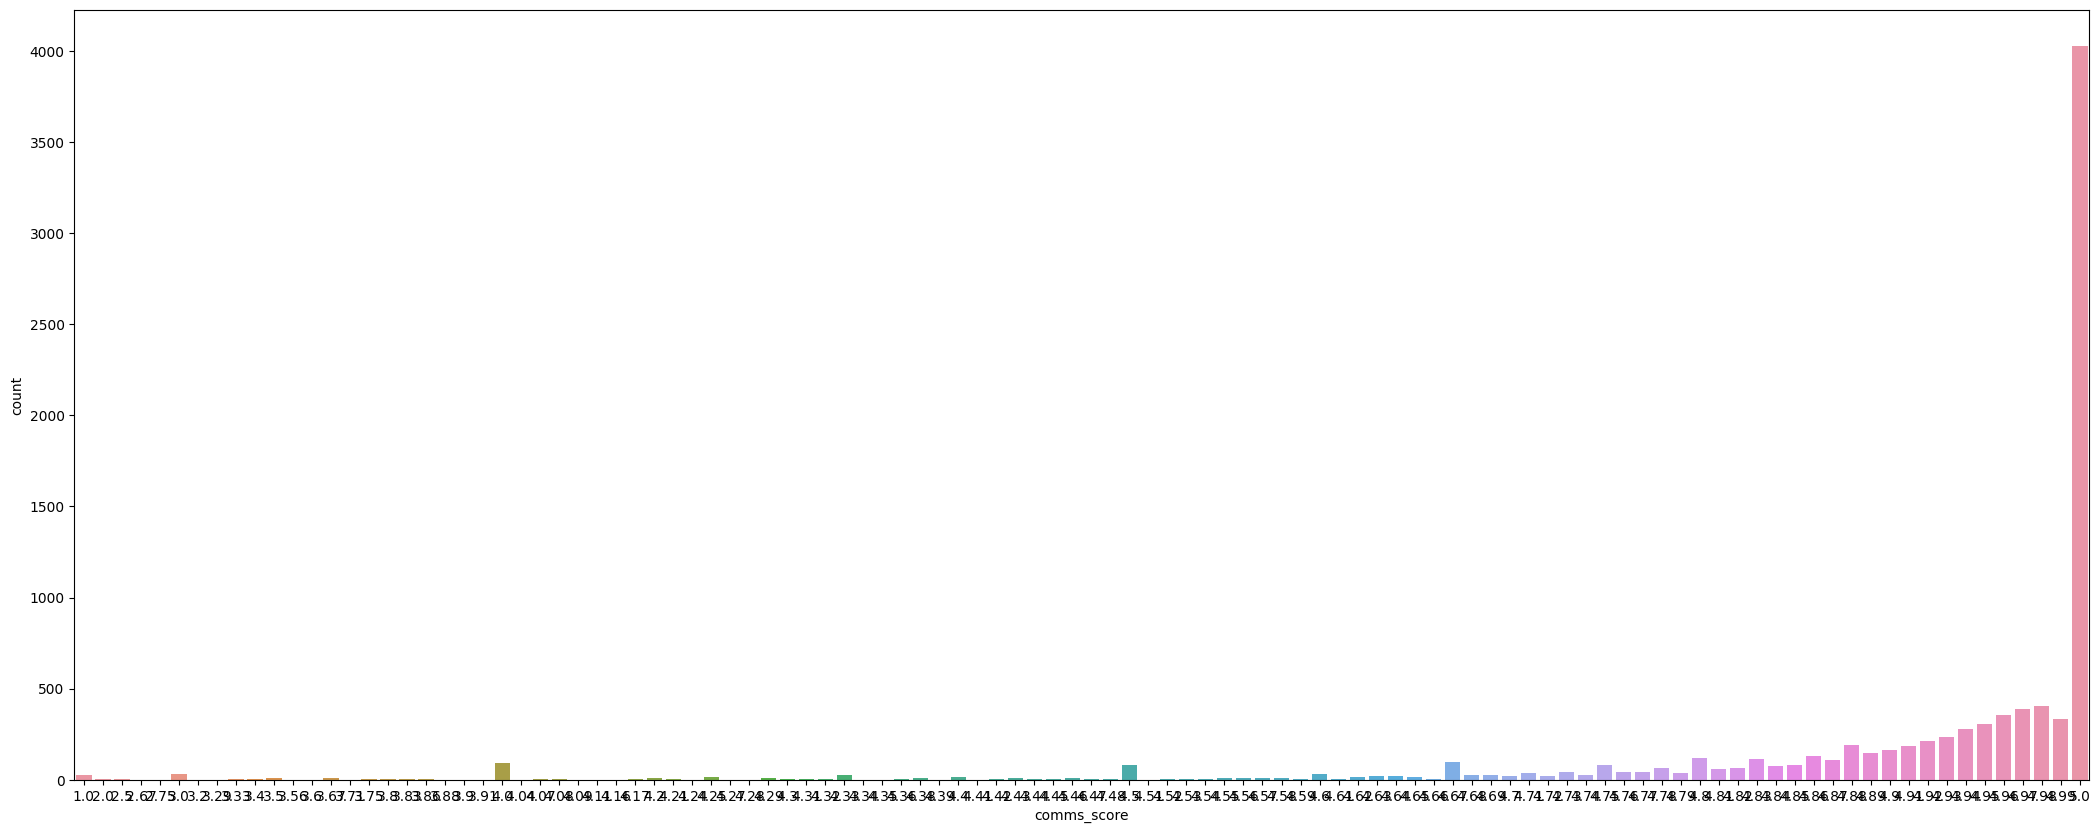

In [808]:
graph = sns.countplot(data=df, x='comms_score')
graph.figure.set_size_inches(26, 10)


- Superhostness  

<AxesSubplot:xlabel='is_superhost', ylabel='count'>

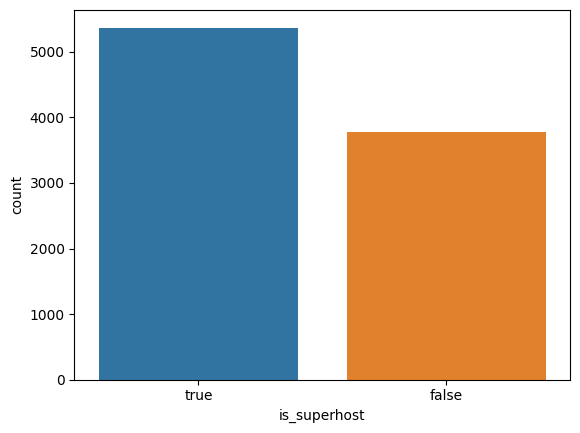

In [809]:
sns.countplot(data=df, x ='is_superhost',  )

##### Conclusions from visualizations  
We can see that the vast majority of hosts:
- responses within an hour.  
- responses to all all messages.    
**but** being superhost is somewhat equally distributed.  

Distribution in numbers:

In [810]:
bold = "\033[1m"
reset = "\033[0m"
print(f"{bold}Response time:{reset} \n{df['response_time'].value_counts()}\n")
print(f"{bold}Response rate:{reset} \n{df['response_rate'].value_counts()}\n")
print(f"{bold}Response rate:{reset} \n{df['comms_score'].value_counts()}\n")
print(f"{bold}Superhostness: {reset}\n{df['is_superhost'].value_counts()}")

Response time: 
within an hour        7603
within a few hours    1000
within a day           441
a few days or more      99
Name: response_time, dtype: int64

Response rate: 
100    7910
99      299
98      159
92      112
90       87
97       86
0        85
96       77
93       40
94       38
80       32
50       27
75       20
95       20
89       19
67       18
86       13
88       13
70       13
91       12
83        9
60        8
87        7
57        7
79        5
78        5
33        4
56        3
71        2
17        2
25        2
40        2
27        2
74        1
64        1
20        1
4         1
73        1
Name: response_rate, dtype: int64

Response rate: 
5.00    4025
4.98     402
4.97     386
4.96     354
4.99     332
        ... 
4.27       1
3.29       1
3.88       1
4.34       1
3.91       1
Name: comms_score, Length: 106, dtype: int64

Superhostness: 
true     5371
false    3772
Name: is_superhost, dtype: int64


Convert response_times to numbers.  

In [811]:
df.replace({'within an hour':4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1}, inplace=True)
df.head()

,response_time,response_rate,comms_score,is_superhost
0,3,100,4.82,true
2,2,100,4.98,true
3,4,100,4.98,true
4,2,90,4.88,false
5,4,100,5.00,true


- Aggregated table  
Grouping the table by superhostness, we see that there are differences in mean values of other columns, though these are not devastating. It might be that communicational behaviour does not reflect whether host is superhost or not.  

In [812]:
grouped = df.groupby(by='is_superhost').mean()
grouped

,response_time,response_rate,comms_score
is_superhost,,,
false,3.608431,95.637593,4.818338
true,3.869298,99.606032,4.939354


### Trying out classifiers  
##### KNN

In [813]:
# Feature and target separation
X = df[['response_time', 'response_rate', 'comms_score']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)       # training the model

# Predict and evaluate
y_prediction = knn.predict(X_test)
acc = accuracy_score(y_test, y_prediction)

print(f"KNN accuracy: {acc:.2f}")

KNN accuracy: 0.70


##### Logistic regression

In [814]:
# Feature and target separation
X = df[['response_time', 'response_rate', 'comms_score']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)

# Model initiation and training
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.67


##### Random Forest Classifier

In [815]:
# Feature and target separation
X = df[['response_time', 'response_rate', 'comms_score']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.70


##### Support Vector Machine (SVM)

In [816]:
# Feature and target separation
X = df[['response_time', 'response_rate', 'comms_score']]
y = df['is_superhost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model initiation and training
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

print(f"SVM Accuracy: {svm_accuracy:.2f}")

SVM Accuracy: 0.66


#### Conclusions from classifiers
As we suspected looking at the aggregated table earlier, response_time, response_rate and comms_score don't do a very good job predicting wheter host is superhost or not. K-NearestNeighbors and Random Forest Classifier seem to achieve the best results, but even those prediction are just only 70%.  